# TUTORIAL FOR TRAVELING SALESMAN PROBLEM

## IMPORTS AND SETUP

In [27]:
!pip install pandas -q

In [28]:
import boto3
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler

In [29]:
import numpy as np
import networkx as nx
import dimod
import dwave_networkx as dnx
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
from collections import defaultdict
import itertools
import pandas as pd

In [30]:
# local imports
from utils_tsp import get_distance, traveling_salesperson

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# Please enter the S3 bucket you created during onboarding in the code below
my_bucket = f"amazon-braket-7c2f2fa45286" # the name of the bucket
my_prefix = "tsp_dwave" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [32]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)

## IMPORT DATASET

Here, we start with a very small dataset comprising four cities only. 

In [33]:
# load dataset
data = pd.read_csv('four_d.txt', sep='\s+', header=None)

In [34]:
# show data set for inter-city distances
data

,0,1,2,3
0,0.0,4.0,1.0,2.0
1,4.0,0.0,2.0,2.0
2,1.0,2.0,0.0,1.0
3,2.0,2.0,1.0,0.0


In [35]:
# distance between two example cities
idx_city1 = 0
idx_city2 = 1
distance = data[idx_city1][idx_city2]
print('Distance between city {} and city {} is {}.'.format(idx_city1, idx_city2, distance))

Distance between city 0 and city 1 is 4.0.


In [36]:
# get number of cities
number_cities = data.shape[0]
print('Total number of cities:', number_cities)

Total number of cities: 4


## SET UP GRAPH

We can generate ```networkx``` graphs from ```pandas``` data frames, as explained [here](https://networkx.github.io/documentation/stable/reference/convert.html#pandas) and in particular [here](https://networkx.github.io/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_adjacency.html?highlight=from%20pandas#networkx.convert_matrix.from_pandas_adjacency).

In [37]:
# G = nx.from_pandas_dataframe(data) 
G = nx.from_pandas_adjacency(data)
# pos = nx.random_layout(G) 
pos = nx.spring_layout(G, seed=seed)

# get characteristics of graph
nodes = G.nodes()
edges = G.edges()
weights = nx.get_edge_attributes(G,'weight');

In [38]:
# print weights of graph
print('Weights of graph:', weights)

Weights of graph: {(0, 1): 4.0, (0, 2): 1.0, (0, 3): 2.0, (1, 2): 2.0, (1, 3): 2.0, (2, 3): 1.0}


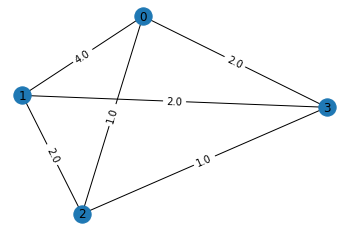

In [39]:
# show graph with weigths
plt.axis('off'); 
nx.draw_networkx(G, pos, with_labels=True);
nx.draw_networkx_edge_labels(G, pos, edge_labels=weights);

The weights of this fully-connected graph correspond to the distances between the cities. 

## QUBO FOR TSP

We can get the QUBO matrix using the ```traveling_salesperson_qubo``` method as described [here](https://docs.ocean.dwavesys.com/projects/dwave-networkx/en/latest/reference/algorithms/generated/dwave_networkx.algorithms.tsp.traveling_salesperson_qubo.html#dwave_networkx.algorithms.tsp.traveling_salesperson_qubo).
This method will return the QUBO with ground states corresponding to a minimum TSP route.
Here, if $|G|$ is the number of nodes (cities) in the original graph, the resulting QUBO will have $|G|^2$ variables/nodes
and $|G|^2(|G|^2-1)/2$ edges. 
There is a quadratic overhead because of the binary encoding $x_{i,j}=1$ if city $i$ is at position $j$ on the route and zero otherwise. 
The Lagrange penalty parameter enforces the constraints that every city should be visited exactly once in our route (i.e., we do not leave out any city and we do not visit cities multiple times). 
As this parameter can be tuned we will run hyperparameter optimization (HPO) to find a good value for this hyperparameter. 

In [40]:
# get QUBO for TSP
tsp_qubo = dnx.algorithms.tsp.traveling_salesperson_qubo(G)

In [41]:
# find default Langrange parameter for enforcing constraints

# set parameters
lagrange = None
weight='weight'

# get corresponding QUBO step by step
N = G.number_of_nodes()

if lagrange is None:
    # If no lagrange parameter provided, set to 'average' tour length.
    # Usually a good estimate for a lagrange parameter is between 75-150%
    # of the objective function value, so we come up with an estimate for 
    # tour length and use that.
    if G.number_of_edges()>0:
        lagrange = G.size(weight=weight)*G.number_of_nodes()/G.number_of_edges()
    else:
        lagrange = 2

print('Default Lagrange parameter:', lagrange)   

Default Lagrange parameter: 8.0


In [42]:
# create list around default value for HPO 
lagrange_list= list(np.arange(int(0.8*lagrange), int(1.1*lagrange)))
print('Lagrange parameter for HPO:', lagrange_list)

Lagrange parameter for HPO: [6, 7]


## SOLUTION WITH SIMULATED ANNEALING

First let us solve the TSP problem with classical simulated annealing.
To this end we can simply call the built-in ```traveling_salesperson(...)``` routine from the ```dwave_networkx``` package using the ```SimulatedAnnealingSampler``` sampler as provided in the standard Ocean tool suite. 

In [43]:
# use (classical) simulated annealing
sampler = dimod.SimulatedAnnealingSampler()
# route = dnx.traveling_salesperson(G, dimod.ExactSolver(), start=0)
route = dnx.traveling_salesperson(G, sampler, start=0)
print('Route found with simulated annealing:', route)

Route found with simulated annealing: [0, 2, 1, 3]


In [44]:
# get the total distance
total_dist = 0
for idx, node in enumerate(route[:-1]):
    dist = data[route[idx+1]][route[idx]]
    total_dist += dist

print('Total distance (without return):', total_dist)

Total distance (without return): 5.0


In [45]:
# add distance between start and end point to complete cycle
return_distance = data[route[0]][route[-1]]
print('Distance between start and end:', return_distance)

Distance between start and end: 2.0


In [46]:
# get distance for full cyle 
distance = total_dist + return_distance
print('Total distance (including return):', distance)

Total distance (including return): 7.0


## SOLUTION WITH QUANTUM ANNEALING ON D-WAVE WITH HPO FOR LAGRANGE PARAMETER

Now let us run the TSP problem on D-Wave's 2000Q QPU, together with hyperparameter optimization for the Langrange parameter.
To this end, we augment the ```traveling_salesperson(...)``` routine with post-processing heuristics that correct for invalid solutions if some cities are not present in the sample produced by D-Wave or if some cities are duplicates in the route. 
The original source code for ```traveling_salesperson(...)``` can be found in the Appendix. 

In [47]:
def TSP(G):
    # run TSP with imported TSP routine
    sampler = BraketDWaveSampler(s3_folder,'arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')
    sampler = EmbeddingComposite(sampler)

    # set parameters
    num_shots = 1000
    start_city = 0
    best_distance = sum(weights.values())
    best_route = [None]*len(G)

    # run HPO to find route
    for lagrange in lagrange_list:
        print('Running quantum annealing for TSP with Lagrange parameter=', lagrange)
        route = traveling_salesperson(G, sampler, lagrange=lagrange, 
                                      start=start_city, num_reads=num_shots, answer_mode="histogram")


        # print distance
        total_dist, distance_with_return = get_distance(route, data)

        # update best values
        if distance_with_return < best_distance:
            best_distance = distance_with_return
            best_route = route

    return best_route, best_distance

TSP(G)
print('---FINAL SOLUTION---')
print('Best solution found with D-Wave:', best_route)
print('Total distance (including return):', best_distance)

Running quantum annealing for TSP with Lagrange parameter= 6
Route found with D-Wave: [0, 2, 1, 3]
Total distance (without return): 5.0
Total distance (including return): 7.0
Running quantum annealing for TSP with Lagrange parameter= 7
Route found with D-Wave: [0, 3, 1, 2]
Total distance (without return): 6.0
Total distance (including return): 7.0
---FINAL SOLUTION---
Best solution found with D-Wave: [0, 2, 1, 3]
Total distance (including return): 7.0


Now let us visualize the solution found by the D-Wave QPU. 
First we plot again the original graph with nodes representing cities and weighted edges representing distances between the cities. 
It is a complete graph showing the distance for every pair of cities. 
Then, we plot below the graph showing the proposed route, with steps labelling the specific sequence connecting the individual stops on the route. 

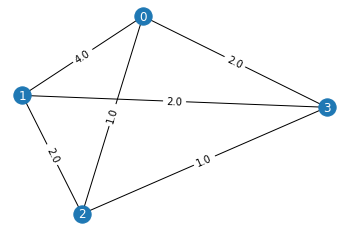

In [48]:
# show original graph with weigths
plt.axis('off'); 
nx.draw_networkx(G, pos, with_labels=True, font_color='w');
nx.draw_networkx_edge_labels(G, pos, edge_labels=weights);

In [49]:
# get mapping from original nodes to position in cycle
node_labels = {list(nodes)[ii]: best_route[ii] for ii in range(number_cities)}

In [50]:
# Construct route as list of (node_i, node_i+1)
sol_graph_base = [(best_route[idx], best_route[idx+1]) for idx in range(len(best_route)-1)]
# Establish weights between nodes along route, allowing for mirrored keys (i.e. weights[(0, 1)] = weights[(1, 0)])
best_weights = {k: weights[k] if k in weights.keys() else weights[(k[1],k[0])] for k in sol_graph_base}
# Rebuild graph containing only route connections
G_best = nx.Graph(sol_graph_base)

route_labels = {x: f'step_{i}={best_weights[x]}' for i, x in enumerate(sol_graph_base)}

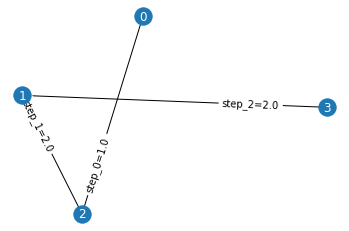

In [51]:
# show solution
plt.axis('off'); 
nx.draw_networkx(G_best, pos, font_color='w');
nx.draw_networkx_edge_labels(G_best, pos, edge_labels=route_labels, label_pos=0.25);

In conclusion, in this part of our tutorial we have solved a very small instance of the famous NP-hard TSP problem using both (classical) simulated annealing and quantum annealing using D-Wave's Ocean tool suite that is natively supported on Amazon Braket. 
While there are classical methods that can solve this problem very efficiently, at least to a very good approximation, this is an educational tutorial focused on the formulation of a specific QUBO problem and the approximate solution thereof using (quantum) annealing methods. 
Below we extend our analysis to larger problem sizes that cannot be embedded on the 2000Q D-Wave chip with Chimera connectivity, but can be run on the larger Advantage chip with $\sim 5000$ physical variables and Pegasus connectivity. 